In [1]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2022-01-28 17:46:21--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  28.8MB/s    in 28s     

2022-01-28 17:46:50 (27.4 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [2]:
!tar -xvf wiki_crop.tar

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
wiki_crop/92/30943192_1890-04-19_1954.jpg
wiki_crop/92/30949092_1943-11-23_1968.jpg
wiki_crop/92/30991792_1921-11-16_1954.jpg
wiki_crop/92/4096292_1970-02-17_2006.jpg
wiki_crop/92/709692_1958-05-03_2011.jpg
wiki_crop/92/909392_1959-02-09_2014.jpg
wiki_crop/92/11942292_1980-02-25_2009.jpg
wiki_crop/92/11955692_1955-09-10_1977.jpg
wiki_crop/92/2194592_1963-09-28_2007.jpg
wiki_crop/92/31935592_1931-08-31_1967.jpg
wiki_crop/92/31959792_1959-04-16_1984.jpg
wiki_crop/92/3196992_1977-07-08_2012.jpg
wiki_crop/92/41970292_1997-05-26_2012.jpg
wiki_crop/92/5194492_1983-04-02_2014.jpg
wiki_crop/92/1290492_1942-12-20_1997.jpg
wiki_crop/92/22989292_1983-07-01_2014.jpg
wiki_crop/92/32944792_1990-12-24_2013.jpg
wiki_crop/92/7297492_1980-07-12_2013.jpg
wiki_crop/92/13937192_1890-12-12_1970.jpg
wiki_crop/92/1399192_1967-12-06_2009.jpg
wiki_crop/92/2398292_1979-08-12_2011.jpg
wiki_crop/92/33928292_1982-02-14_2011.jpg
wiki_crop/

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
class GAN():
    def __init__(self, x, y, z):

        self.img_rows = x
        self.img_cols = y
        self.channels = z
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(
            loss='binary_crossentropy', 
            optimizer=optimizer)

        z = Input(shape=(100,))
        img = self.generator(z)

        self.discriminator.trainable = False
        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()
        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)
        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            valid_y = np.array([1] * batch_size)

            g_loss = self.combined.train_on_batch(noise, valid_y)

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_gan_face/face_%d.png" % epoch)
        plt.close()

In [4]:
!mkdir images_gan_face

In [5]:
import os, sys
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

dataset = []
        
folder = "wiki_crop/"

# Original Dimensions
image_width = 96
image_height = 96
channels = 3
nb_classes = 1
        
onlyfolder = [f for f in os.listdir(folder)]

for fold in onlyfolder :
    if len(dataset) > 20000 :
        break
    try : 
        onlyfiles = [f for f in os.listdir(folder+fold) if os.path.isfile(os.path.join(folder+fold, f))]

        train_files = []
        i=0

        for _file in onlyfiles:
            train_files.append(_file)

        print("Files in train_files: %d" % len(train_files))

        i = 0
        for _file in train_files:
            img = load_img(folder + fold + "/" + _file)  # this is a PIL image
            img.thumbnail((image_width, image_height))
            # Convert to Numpy Array
            x = img_to_array(img)  
            try : 
                x = x.reshape((image_width, image_height, channels)).astype(int)
                # Normalize
                dataset.append(x)
                i += 1
                if i % 250 == 0:
                    print("%d images to array" % i)
            except :
                continue
    except : 
        continue
        
np_data = np.array(dataset)
np.save('X_face.npy', np_data)

Files in train_files: 668
250 images to array
Files in train_files: 621
250 images to array
Files in train_files: 629
250 images to array
Files in train_files: 645
250 images to array
Files in train_files: 617
250 images to array
Files in train_files: 606
250 images to array
Files in train_files: 600
250 images to array
Files in train_files: 658
250 images to array
Files in train_files: 632
250 images to array
Files in train_files: 618
250 images to array
Files in train_files: 631
250 images to array
Files in train_files: 601
250 images to array
Files in train_files: 636
250 images to array
Files in train_files: 661
250 images to array
Files in train_files: 611
250 images to array
Files in train_files: 629
250 images to array
Files in train_files: 637
250 images to array
Files in train_files: 649
250 images to array
Files in train_files: 607
250 images to array
Files in train_files: 610
250 images to array
Files in train_files: 612
250 images to array
Files in train_files: 612
250 imag

In [ ]:
import numpy as np
faces = np.load("X_face.npy")
faces.shape

(20250, 96, 96, 3)

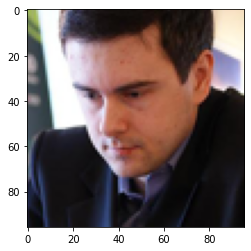

In [ ]:
image =faces[0]
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
sample = train